In [1]:
# Install required packages.
!pip install torch-geometric
!pip install sentence_transformers

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero
import torch_geometric.transforms as T

In [3]:
dataset_path = '/tmp/'
dataset = MovieLens(root=dataset_path)



In [4]:
import numpy as np

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)


for epoch in range(1, 301):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 001, Loss: 19.6523, Train: 3.4235, Val: 3.4215, Test: 3.4255
Epoch: 002, Loss: 18.1506, Train: 3.2421, Val: 3.2414, Test: 3.2449
Epoch: 003, Loss: 16.2989, Train: 2.9338, Val: 2.9366, Test: 2.9389
Epoch: 004, Loss: 13.4781, Train: 2.3949, Val: 2.4040, Test: 2.4036
Epoch: 005, Loss: 9.5574, Train: 1.5554, Val: 1.5742, Test: 1.5661
Epoch: 006, Loss: 6.2277, Train: 1.1652, Val: 1.1671, Test: 1.1445
Epoch: 007, Loss: 9.3538, Train: 1.1394, Val: 1.1435, Test: 1.1210
Epoch: 008, Loss: 8.9599, Train: 1.1184, Val: 1.1366, Test: 1.1186
Epoch: 009, Loss: 6.6137, Train: 1.4299, Val: 1.4493, Test: 1.4395
Epoch: 010, Loss: 5.9879, Train: 1.7603, Val: 1.7760, Test: 1.7707
Epoch: 011, Loss: 6.6033, Train: 1.9531, Val: 1.9663, Test: 1.9629
Epoch: 012, Loss: 7.2658, Train: 2.0087, Val: 2.0210, Test: 2.0181
Epoch: 013, Loss: 7.4846, Train: 1.9535, Val: 1.9664, Test: 1.9629
Epoch: 014, Loss: 7.2387, Train: 1.8085, Val: 1.8230, Test: 1.8182
Epoch: 015, Loss: 6.6829, Train: 1.5952, Val: 1.6122, Test

KeyboardInterrupt: ignored

## Задание

1) Подберите оптимальные параметры для сети из примера выше(2 балла)

2) Попробуйте вместо GraphSage модуль Graph Attention и также подберите оптимальные параметры  (2 балла)


# Задание 1

### Я попробовал добавить 2 линейных слоя в энкодер + изменить lr с 1e-2 на 1e-3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, int(hidden_channels / 2))
        self.lin3 = Linear(int(hidden_channels / 2), int(hidden_channels / 4))
        self.lin4 = Linear(int(hidden_channels / 4), 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).relu()
        z = self.lin3(z).relu()
        z = self.lin4(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)



train_loss = []
test_loss = []
for epoch in range(1, 301):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 010, Loss: 17.7563, Train: 3.3704, Val: 3.3893, Test: 3.3837
Epoch: 020, Loss: 16.7538, Train: 3.2641, Val: 3.2832, Test: 3.2777
Epoch: 030, Loss: 14.1312, Train: 2.9544, Val: 2.9745, Test: 2.9694
Epoch: 040, Loss: 8.5493, Train: 2.0813, Val: 2.1040, Test: 2.1006
Epoch: 050, Loss: 6.8578, Train: 1.0985, Val: 1.1026, Test: 1.1048
Epoch: 060, Loss: 5.9755, Train: 1.4463, Val: 1.4674, Test: 1.4655
Epoch: 070, Loss: 6.0122, Train: 1.4760, Val: 1.4981, Test: 1.4955
Epoch: 080, Loss: 5.8565, Train: 1.2556, Val: 1.2745, Test: 1.2728
Epoch: 090, Loss: 5.7482, Train: 1.3383, Val: 1.3599, Test: 1.3571
Epoch: 100, Loss: 5.6750, Train: 1.3313, Val: 1.3535, Test: 1.3501
Epoch: 110, Loss: 5.5918, Train: 1.2812, Val: 1.3033, Test: 1.2996
Epoch: 120, Loss: 5.4984, Train: 1.2956, Val: 1.3187, Test: 1.3143
Epoch: 130, Loss: 5.3891, Train: 1.2676, Val: 1.2911, Test: 1.2860
Epoch: 140, Loss: 5.2585, Train: 1.2543, Val: 1.2785, Test: 1.2723
Epoch: 150, Loss: 5.1067, Train: 1.2377, Val: 1.2626, Test:

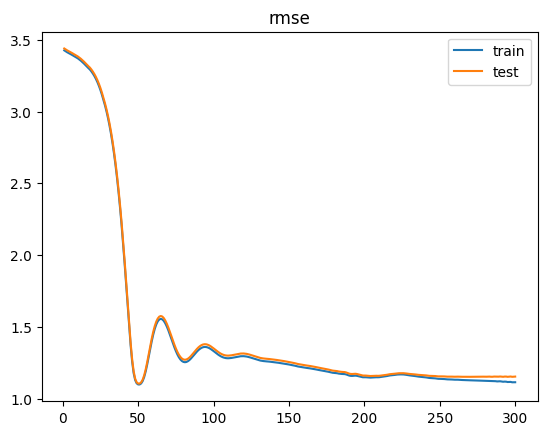

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

### А здесь увеличил число скрытых каналов + вернул lr=1e-2

In [ ]:
model = Model(hidden_channels=42).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
for epoch in range(1, 301):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 010, Loss: 6.5398, Train: 1.5177, Val: 1.5492, Test: 1.5448
Epoch: 020, Loss: 6.2622, Train: 1.1742, Val: 1.2031, Test: 1.1984
Epoch: 030, Loss: 5.4599, Train: 1.0785, Val: 1.1064, Test: 1.1003
Epoch: 040, Loss: 4.6272, Train: 1.0716, Val: 1.0993, Test: 1.0898
Epoch: 050, Loss: 3.8686, Train: 1.1453, Val: 1.1671, Test: 1.1517
Epoch: 060, Loss: 3.6551, Train: 1.2442, Val: 1.2666, Test: 1.2459
Epoch: 070, Loss: 3.5027, Train: 1.1491, Val: 1.1779, Test: 1.1595
Epoch: 080, Loss: 3.4202, Train: 1.1226, Val: 1.1552, Test: 1.1378
Epoch: 090, Loss: 3.3189, Train: 1.1464, Val: 1.1800, Test: 1.1648
Epoch: 100, Loss: 3.1921, Train: 1.1332, Val: 1.1695, Test: 1.1606
Epoch: 110, Loss: 3.0621, Train: 1.1108, Val: 1.1533, Test: 1.1500
Epoch: 120, Loss: 2.9731, Train: 1.1103, Val: 1.1599, Test: 1.1566
Epoch: 130, Loss: 2.9158, Train: 1.1078, Val: 1.1637, Test: 1.1593
Epoch: 140, Loss: 2.8740, Train: 1.1022, Val: 1.1592, Test: 1.1558
Epoch: 150, Loss: 2.8385, Train: 1.0929, Val: 1.1503, Test: 1.

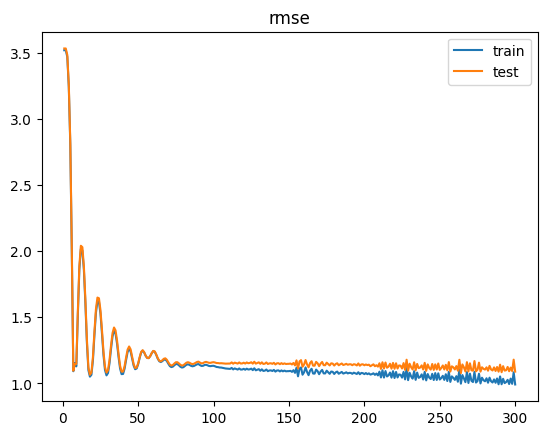

In [ ]:
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

### Здесь я еще больше увеличил количество скрытых слоев

In [ ]:
model = Model(hidden_channels=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
for epoch in range(1, 1000):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 100, Loss: 2.6183, Train: 1.0580, Val: 1.1250, Test: 1.1264
Epoch: 200, Loss: 1.9786, Train: 0.9659, Val: 1.0817, Test: 1.0853
Epoch: 300, Loss: 1.9155, Train: 0.9668, Val: 1.1107, Test: 1.1197
Epoch: 400, Loss: 1.5162, Train: 0.8536, Val: 1.0539, Test: 1.0659
Epoch: 500, Loss: 1.3866, Train: 0.8182, Val: 1.0586, Test: 1.0631
Epoch: 600, Loss: 1.3389, Train: 0.7907, Val: 1.0689, Test: 1.0679
Epoch: 700, Loss: 1.1373, Train: 0.7779, Val: 1.0876, Test: 1.0820
Epoch: 800, Loss: 1.0658, Train: 0.7467, Val: 1.0898, Test: 1.0853
Epoch: 900, Loss: 0.9278, Train: 0.7141, Val: 1.0898, Test: 1.0862


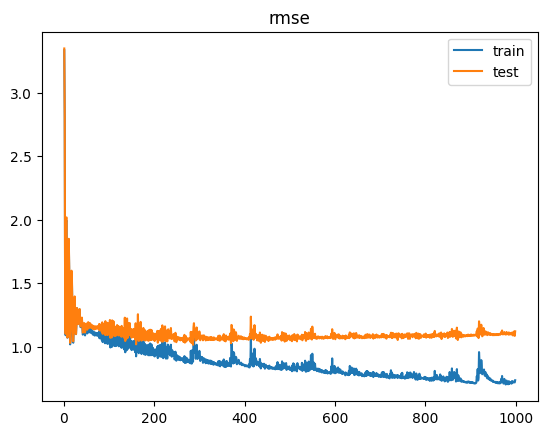

In [ ]:
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

### В целом видно, что порог преодолен

### Задание 2

### Здесь я уже не стал так подробно описывать выбор конфигурации - шаги все те же самые. В итоге количество скрытых слоев понизил - оказалось, что начиная где-то с 70 слоев лосс не падает ниже 1.2

In [6]:
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero, GATConv

In [7]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=num_heads, dropout=0.6, add_self_loops=False)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=0.6, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, int(hidden_channels / 2))
        self.lin3 = Linear(int(hidden_channels / 2), int(hidden_channels / 4))
        self.lin4 = Linear(int(hidden_channels / 4), 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).relu()
        z = self.lin3(z).relu()
        z = self.lin4(z)
        return z.view(-1)

In [8]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels, num_heads)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [10]:
model = Model(hidden_channels=100, num_heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


train_loss = []
test_loss = []
for epoch in range(1, 1001):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 100, Loss: 4.4485, Train: 1.2393, Val: 1.2369, Test: 1.2245
Epoch: 200, Loss: 3.6662, Train: 1.0919, Val: 1.1113, Test: 1.0824
Epoch: 300, Loss: 3.3085, Train: 1.1109, Val: 1.1455, Test: 1.1164
Epoch: 400, Loss: 3.1659, Train: 1.0224, Val: 1.0752, Test: 1.0400
Epoch: 500, Loss: 3.0848, Train: 1.0790, Val: 1.1307, Test: 1.0995
Epoch: 600, Loss: 2.9730, Train: 1.0317, Val: 1.0895, Test: 1.0633
Epoch: 700, Loss: 2.8478, Train: 1.0691, Val: 1.1275, Test: 1.1014
Epoch: 800, Loss: 2.8364, Train: 1.0113, Val: 1.0752, Test: 1.0474
Epoch: 900, Loss: 2.7591, Train: 1.0514, Val: 1.1124, Test: 1.0910
Epoch: 1000, Loss: 2.6715, Train: 1.0573, Val: 1.1236, Test: 1.1047


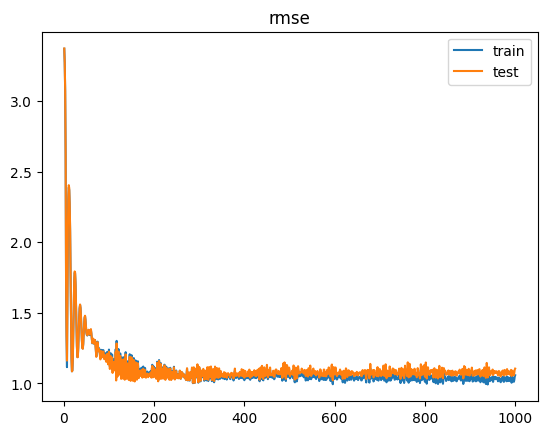

In [13]:
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

In [16]:
model = Model(hidden_channels=50, num_heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)


train_loss = []
test_loss = []
for epoch in range(1, 1001):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 100, Loss: 5.1890, Train: 1.2986, Val: 1.2948, Test: 1.2971
Epoch: 200, Loss: 4.1113, Train: 1.0892, Val: 1.0892, Test: 1.0691
Epoch: 300, Loss: 3.8117, Train: 1.0512, Val: 1.0671, Test: 1.0407
Epoch: 400, Loss: 3.6519, Train: 1.0753, Val: 1.1039, Test: 1.0722
Epoch: 500, Loss: 3.6122, Train: 1.0451, Val: 1.0800, Test: 1.0447
Epoch: 600, Loss: 3.4563, Train: 1.0363, Val: 1.0756, Test: 1.0396
Epoch: 700, Loss: 3.4264, Train: 1.0830, Val: 1.1213, Test: 1.0893
Epoch: 800, Loss: 3.3637, Train: 1.0520, Val: 1.0936, Test: 1.0585
Epoch: 900, Loss: 3.2877, Train: 1.0558, Val: 1.0954, Test: 1.0601
Epoch: 1000, Loss: 3.2035, Train: 1.0650, Val: 1.1081, Test: 1.0732


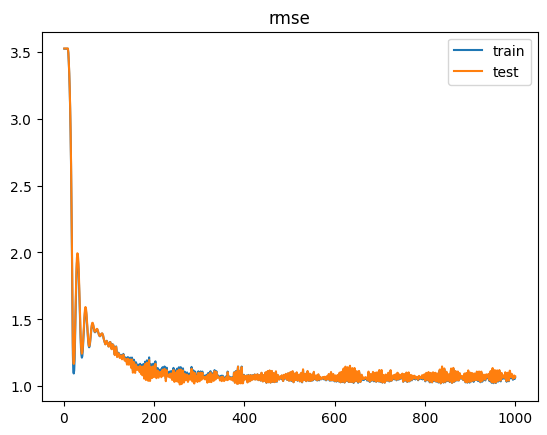

In [17]:
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

### Попробовал поучить еще 1000 эпох. В итоге дошел до момента, когда модель точно перестала давать меньший лосс, и остановился


In [18]:
for epoch in range(1001, 2001):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    train_loss.append(train_rmse)
    test_loss.append(test_rmse)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

Epoch: 1100, Loss: 3.1468, Train: 1.0790, Val: 1.1223, Test: 1.0906
Epoch: 1200, Loss: 3.0988, Train: 1.0979, Val: 1.1405, Test: 1.1111
Epoch: 1300, Loss: 3.0680, Train: 1.0467, Val: 1.0905, Test: 1.0567
Epoch: 1400, Loss: 3.0188, Train: 1.0669, Val: 1.1128, Test: 1.0804
Epoch: 1500, Loss: 3.0108, Train: 1.0394, Val: 1.0865, Test: 1.0523
Epoch: 1600, Loss: 2.9485, Train: 1.0837, Val: 1.1289, Test: 1.0995
Epoch: 1700, Loss: 2.9286, Train: 1.0610, Val: 1.1084, Test: 1.0786
Epoch: 1800, Loss: 2.8987, Train: 1.0564, Val: 1.1031, Test: 1.0728
Epoch: 1900, Loss: 2.8753, Train: 1.0708, Val: 1.1170, Test: 1.0872
Epoch: 2000, Loss: 2.8309, Train: 1.0505, Val: 1.1001, Test: 1.0682


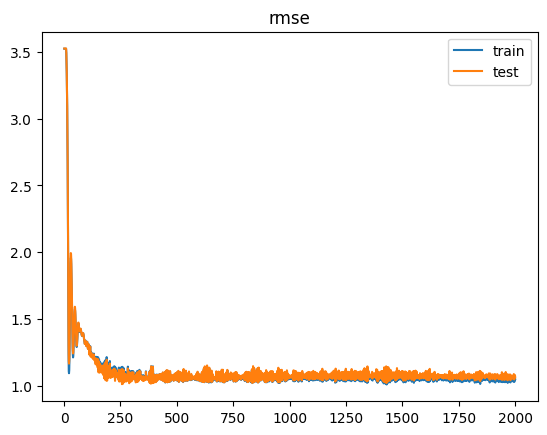

In [19]:
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test')
plt.title('rmse')
plt.legend()
plt.show()

### Конечный лосс остался где-то на уровне 1.05-1.08. Однако по сравнению с GraphSage переобучаемости нет